# 🧠 Brain Tumor Detection - Complete Training Pipeline

**Google Colab Notebook for Cloud-based Training**

This notebook provides the complete pipeline for:
1. Dataset analysis and visualization
2. Automated brain region extraction (CV)
3. VGG-16 model training with transfer learning
4. Model evaluation with medical-context metrics

---

⚠️ **Important**: Run this notebook with **GPU runtime** for faster training:
- Go to `Runtime` → `Change runtime type` → Select `T4 GPU`

## 0. Setup and Installation

In [11]:
# Check GPU availability
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU is available! Training will be fast.")
else:
    print("⚠️ No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is available! Training will be fast.


In [12]:
# Mount Google Drive (for persistent storage)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

YES_PATH = "/content/drive/MyDrive/Brain_Tumor_Detection/data/raw/yes"
NO_PATH  = "/content/drive/MyDrive/Brain_Tumor_Detection/data/raw/no"

print("YES images:", len(os.listdir(YES_PATH)))
print("NO images:", len(os.listdir(NO_PATH)))


YES images: 95
NO images: 98


In [15]:
# Create project directory in Google Drive
import os
from pathlib import Path

# Project paths
DRIVE_PATH = Path("/content/drive/MyDrive/Brain_Tumor_Detection")
DATA_DIR = DRIVE_PATH / "data"
RAW_DIR = DATA_DIR / "raw"
SPLITS_DIR = DATA_DIR / "splits"
PROCESSED_DIR = DATA_DIR / "processed"
MODEL_DIR = DRIVE_PATH / "saved_models"

# Create directories
for d in [RAW_DIR / "yes", RAW_DIR / "no",
          SPLITS_DIR / "train" / "yes", SPLITS_DIR / "train" / "no",
          SPLITS_DIR / "val" / "yes", SPLITS_DIR / "val" / "no",
          SPLITS_DIR / "test" / "yes", SPLITS_DIR / "test" / "no",
          PROCESSED_DIR / "train" / "yes", PROCESSED_DIR / "train" / "no",
          PROCESSED_DIR / "val" / "yes", PROCESSED_DIR / "val" / "no",
          PROCESSED_DIR / "test" / "yes", PROCESSED_DIR / "test" / "no",
          MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"✅ Project directory created at: {DRIVE_PATH}")
print(f"\nUpload your dataset to:")
print(f"  - {RAW_DIR / 'yes'} (tumor images)")
print(f"  - {RAW_DIR / 'no'} (no tumor images)")

✅ Project directory created at: /content/drive/MyDrive/Brain_Tumor_Detection

Upload your dataset to:
  - /content/drive/MyDrive/Brain_Tumor_Detection/data/raw/yes (tumor images)
  - /content/drive/MyDrive/Brain_Tumor_Detection/data/raw/no (no tumor images)


### ⬆️ Upload Your Dataset

Before continuing, upload your MRI images to Google Drive:

1. Open Google Drive in a new tab
2. Navigate to `Brain_Tumor_Detection/data/raw/`
3. Upload tumor images to `yes/` folder
4. Upload no-tumor images to `no/` folder

**OR** use the upload cell below to upload a ZIP file:

In [16]:
# Alternative: Upload ZIP file and extract
from google.colab import files
import zipfile

print("Upload your dataset ZIP file (should contain 'yes' and 'no' folders):")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(str(RAW_DIR))
        print(f"✅ Extracted {filename} to {RAW_DIR}")

Upload your dataset ZIP file (should contain 'yes' and 'no' folders):


Saving Dataset.rar to Dataset.rar


## 1. Configuration

In [17]:
# Configuration
import random
import numpy as np

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Model parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10  # Frozen base
EPOCHS_PHASE2 = 20  # Fine-tuning
LEARNING_RATE_PHASE1 = 1e-3
LEARNING_RATE_PHASE2 = 1e-5
DENSE_UNITS = 256
DROPOUT_RATE = 0.5

# Classes
CLASSES = ["no", "yes"]

print("Configuration loaded!")

Configuration loaded!


## 2. Dataset Analysis

DATASET ANALYSIS
Tumor (YES):    155 images (61.3%)
No Tumor (NO):  98 images (38.7%)
Total:          253 images

Class Imbalance Ratio: 1.58:1


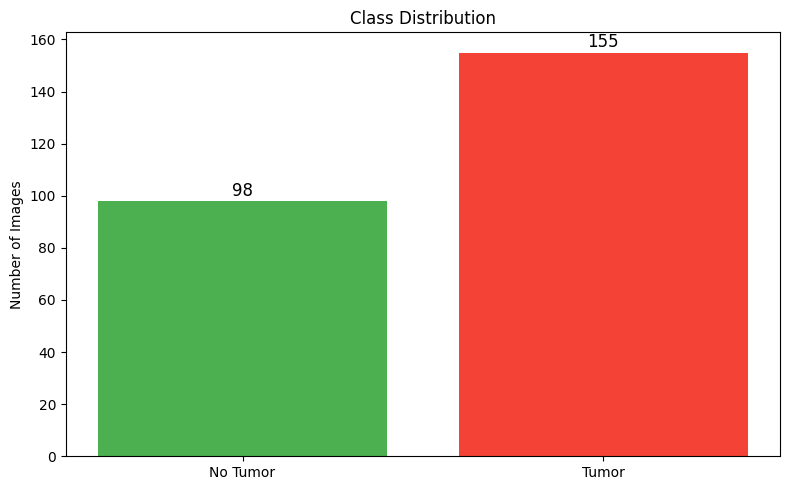

In [18]:
import matplotlib.pyplot as plt
import cv2
from collections import Counter

def count_images(directory):
    """Count images in a directory."""
    extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG'}
    count = 0
    for f in Path(directory).iterdir():
        if f.suffix in extensions:
            count += 1
    return count

# Count images per class
yes_count = count_images(RAW_DIR / "yes")
no_count = count_images(RAW_DIR / "no")
total = yes_count + no_count

print("=" * 50)
print("DATASET ANALYSIS")
print("=" * 50)
print(f"Tumor (YES):    {yes_count} images ({yes_count/total*100:.1f}%)")
print(f"No Tumor (NO):  {no_count} images ({no_count/total*100:.1f}%)")
print(f"Total:          {total} images")
print(f"\nClass Imbalance Ratio: {max(yes_count, no_count) / min(yes_count, no_count):.2f}:1")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['No Tumor', 'Tumor'], [no_count, yes_count],
              color=['#4CAF50', '#F44336'])
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution')

# Add value labels on bars
for bar, count in zip(bars, [no_count, yes_count]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Sample Tumor Images (YES):


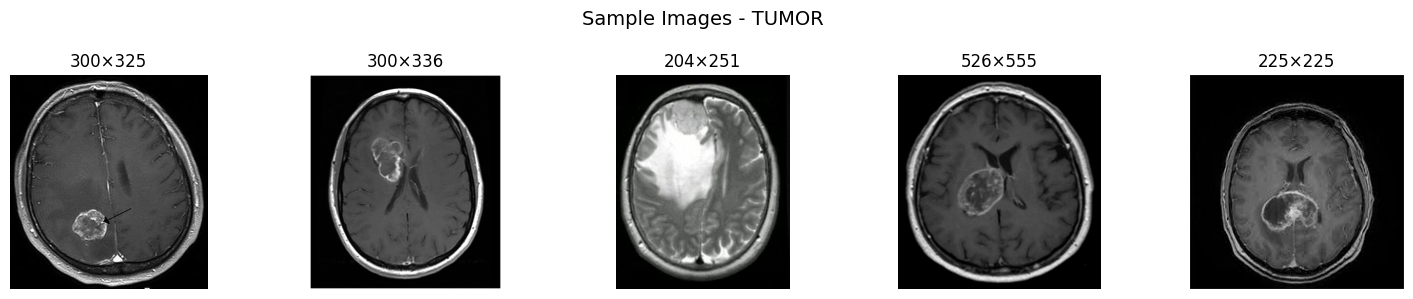


Sample No-Tumor Images (NO):


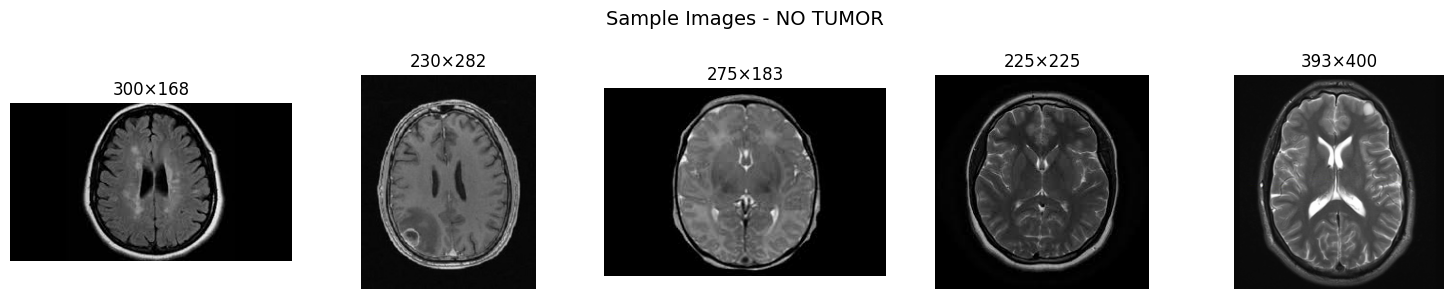

In [19]:
# Visualize sample images
def show_samples(directory, class_name, n=5):
    """Display sample images from a class."""
    images = list(Path(directory).glob('*'))
    images = [f for f in images if f.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}]
    samples = random.sample(images, min(n, len(images)))

    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    fig.suptitle(f'Sample Images - {class_name.upper()}', fontsize=14)

    for ax, img_path in zip(axes.flat, samples):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{img.shape[1]}×{img.shape[0]}')

    plt.tight_layout()
    plt.show()

print("Sample Tumor Images (YES):")
show_samples(RAW_DIR / "yes", "Tumor")

print("\nSample No-Tumor Images (NO):")
show_samples(RAW_DIR / "no", "No Tumor")

## 3. Data Splitting (Train/Val/Test)

In [20]:
import shutil

def get_image_files(directory):
    """Get all image files from directory."""
    extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG'}
    files = [f for f in Path(directory).iterdir() if f.suffix in extensions]
    return sorted(files)

def split_data(source_dir, output_dir, train_ratio, val_ratio, test_ratio):
    """Split data into train/val/test with stratification."""
    stats = {'train': {'yes': 0, 'no': 0},
             'val': {'yes': 0, 'no': 0},
             'test': {'yes': 0, 'no': 0}}

    for class_name in ['yes', 'no']:
        files = get_image_files(source_dir / class_name)
        random.shuffle(files)

        n = len(files)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        splits = [
            ('train', files[:train_end]),
            ('val', files[train_end:val_end]),
            ('test', files[val_end:])
        ]

        for split_name, split_files in splits:
            out_dir = output_dir / split_name / class_name
            out_dir.mkdir(parents=True, exist_ok=True)

            for f in split_files:
                shutil.copy2(f, out_dir / f.name)
                stats[split_name][class_name] += 1

    return stats

# Split the data
print("Splitting data into train/val/test...")
split_stats = split_data(RAW_DIR, SPLITS_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print("\n" + "=" * 50)
print("DATA SPLIT SUMMARY")
print("=" * 50)
for split in ['train', 'val', 'test']:
    total = split_stats[split]['yes'] + split_stats[split]['no']
    print(f"{split.upper():6}: Yes={split_stats[split]['yes']:3}, No={split_stats[split]['no']:3}, Total={total:3}")

Splitting data into train/val/test...

DATA SPLIT SUMMARY
TRAIN : Yes=108, No= 68, Total=176
VAL   : Yes= 23, No= 14, Total= 37
TEST  : Yes= 24, No= 16, Total= 40


## 4. Brain Region Extraction (Computer Vision)

In [21]:
def crop_brain_region(image, target_size=(224, 224)):
    """
    Extract brain region from MRI image.

    Pipeline:
    1. Convert to grayscale
    2. Gaussian blur
    3. Otsu thresholding
    4. Contour detection
    5. Bounding box extraction
    6. Resize
    """
    original = image.copy()

    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return cv2.resize(original, target_size), False

    # Filter by area
    valid = [c for c in contours if cv2.contourArea(c) >= 1000]

    if not valid:
        return cv2.resize(original, target_size), False

    # Largest contour
    largest = max(valid, key=cv2.contourArea)

    # Bounding box with padding
    x, y, w, h = cv2.boundingRect(largest)
    padding = 10
    height, width = gray.shape[:2]

    x1 = max(0, x - padding)
    y1 = max(0, y - padding)
    x2 = min(width, x + w + padding)
    y2 = min(height, y + h + padding)

    # Crop and resize
    cropped = original[y1:y2, x1:x2]
    resized = cv2.resize(cropped, target_size)

    return resized, True

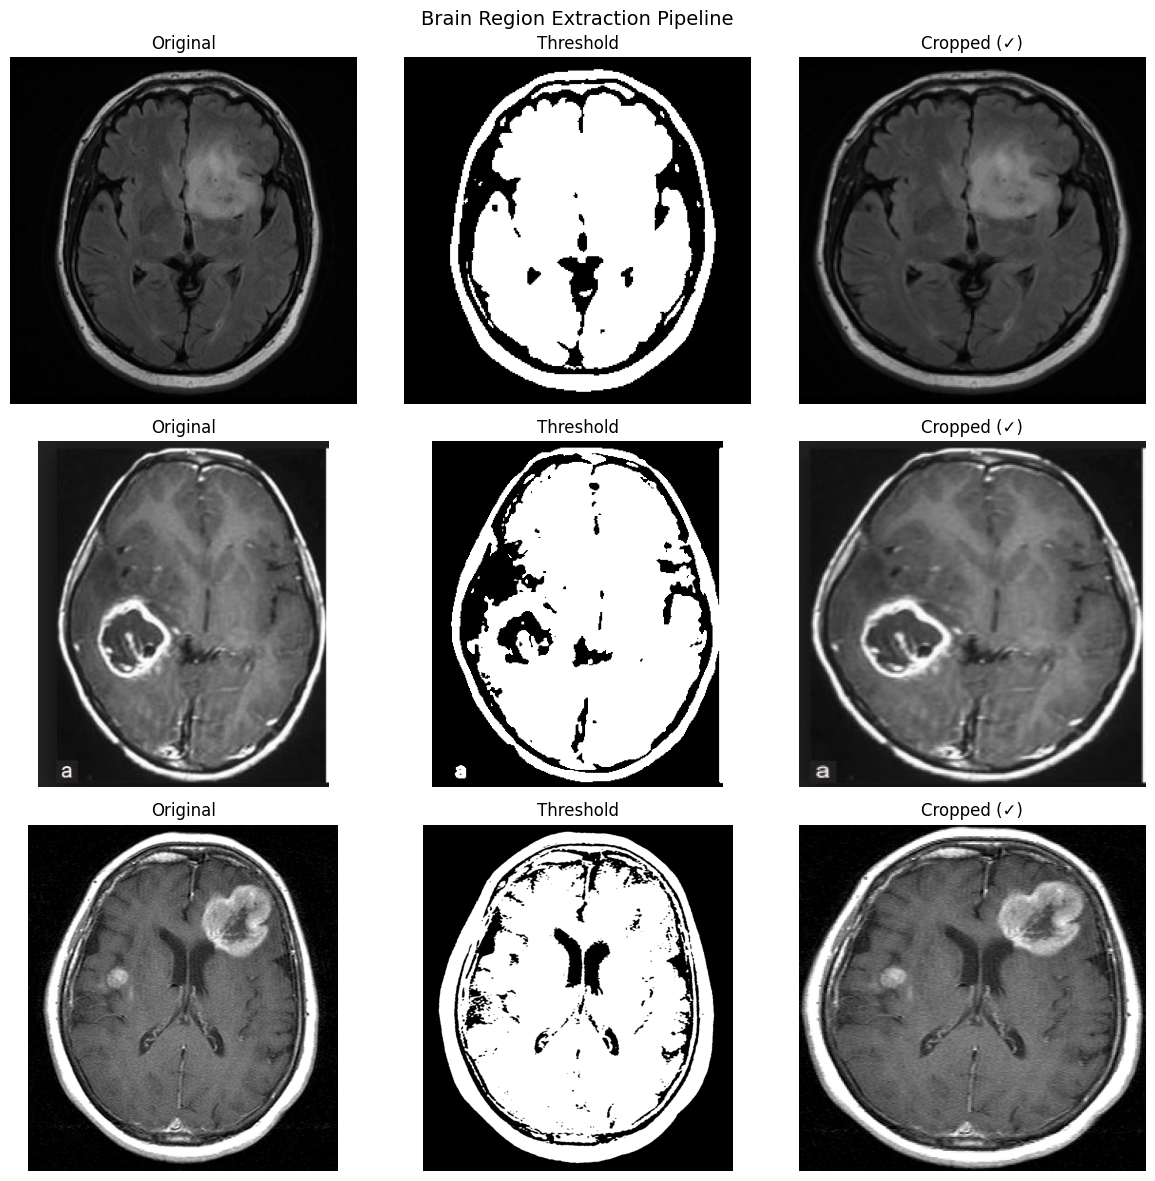

In [22]:
# Visualize brain cropping pipeline
sample_files = list((SPLITS_DIR / "train" / "yes").glob('*'))[:3]

fig, axes = plt.subplots(len(sample_files), 3, figsize=(12, 4*len(sample_files)))

for i, img_path in enumerate(sample_files):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get grayscale for visualization
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(cv2.GaussianBlur(gray, (5,5), 0), 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Crop
    cropped, success = crop_brain_region(img)
    cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)

    # Plot
    axes[i, 0].imshow(img_rgb)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(thresh, cmap='gray')
    axes[i, 1].set_title('Threshold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(cropped_rgb)
    axes[i, 2].set_title(f'Cropped ({"✓" if success else "fallback"})')
    axes[i, 2].axis('off')

plt.suptitle('Brain Region Extraction Pipeline', fontsize=14)
plt.tight_layout()
plt.show()

In [23]:
# Process all splits
from tqdm import tqdm

def process_split(input_dir, output_dir):
    """Process all images in a split directory."""
    stats = {'processed': 0, 'fallback': 0}

    for class_name in ['yes', 'no']:
        in_class_dir = input_dir / class_name
        out_class_dir = output_dir / class_name
        out_class_dir.mkdir(parents=True, exist_ok=True)

        files = get_image_files(in_class_dir)

        for f in tqdm(files, desc=f'{class_name}'):
            img = cv2.imread(str(f))
            if img is None:
                continue

            cropped, success = crop_brain_region(img)
            cv2.imwrite(str(out_class_dir / f"{f.stem}.jpg"), cropped)

            stats['processed'] += 1
            if not success:
                stats['fallback'] += 1

    return stats

print("Processing all images...\n")

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    stats = process_split(SPLITS_DIR / split, PROCESSED_DIR / split)
    print(f"  Processed: {stats['processed']}, Fallback: {stats['fallback']}")

print("\n✅ All images processed!")

Processing all images...


TRAIN:


no: 100%|██████████| 68/68 [00:00<00:00, 71.18it/s]


  Processed: 176, Fallback: 0

VAL:


no: 100%|██████████| 14/14 [00:00<00:00, 66.81it/s]


  Processed: 37, Fallback: 0

TEST:


no: 100%|██████████| 16/16 [00:00<00:00, 67.50it/s]

  Processed: 40, Fallback: 0

✅ All images processed!


## 5. Data Generators

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Val/Test generator (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DIR / 'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    PROCESSED_DIR / 'val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    PROCESSED_DIR / 'test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,
    shuffle=False
)

print(f"\nClass indices: {train_generator.class_indices}")

Found 176 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 40 images belonging to 2 classes.

Class indices: {'no': 0, 'yes': 1}


In [25]:
# Compute class weights for imbalanced data
from collections import Counter

counter = Counter(train_generator.classes)
total = len(train_generator.classes)
n_classes = len(counter)

class_weights = {
    class_idx: total / (n_classes * count)
    for class_idx, count in counter.items()
}

print(f"Class weights: {class_weights}")
print(f"  Class 0 (no tumor): weight = {class_weights[0]:.3f}")
print(f"  Class 1 (tumor):    weight = {class_weights[1]:.3f}")

Class weights: {np.int32(0): 1.2941176470588236, np.int32(1): 0.8148148148148148}
  Class 0 (no tumor): weight = 1.294
  Class 1 (tumor):    weight = 0.815


## 6. Build VGG-16 Model

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam

def build_model(freeze_base=True):
    """Build VGG-16 with custom classification head."""

    # Load VGG-16 base
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base layers
    if freeze_base:
        for layer in base_model.layers:
            layer.trainable = False

    # Custom head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(DENSE_UNITS, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output, name='VGG16_BrainTumor')

    return model

# Build model
model = build_model(freeze_base=True)

# Compile
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "VGG16_BrainTumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           25

 Total params: 14,848,321 (56.64 MB)

 Trainable params: 132,609 (518.00 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

## 7. Training - Phase 1 (Frozen Base)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
callbacks_phase1 = [
    ModelCheckpoint(
        str(MODEL_DIR / 'best_model_phase1.h5'),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("=" * 50)
print("PHASE 1: Transfer Learning (Frozen Base)")
print("=" * 50)

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1
)

PHASE 1: Transfer Learning (Frozen Base)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4289 - auc: 0.4133 - loss: 4.3842 - precision: 0.5948 - recall: 0.3641
Epoch 1: val_loss improved from inf to 3.55192, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.4383 - auc: 0.4339 - loss: 4.3567 - precision: 0.6004 - recall: 0.3716 - val_accuracy: 0.8378 - val_auc: 0.9876 - val_loss: 3.5519 - val_precision: 0.7931 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6907 - auc: 0.8313 - loss: 3.7450 - precision: 0.8565 - recall: 0.6314
Epoch 2: val_loss improved from 3.55192 to 3.24476, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - accuracy: 0.6967 - auc: 0.8348 - loss: 3.7331 - precision: 0.8556 - recall: 0.6391 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 3.2448 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7754 - auc: 0.9430 - loss: 3.3916 - precision: 0.9069 - recall: 0.7057
Epoch 3: val_loss improved from 3.24476 to 3.04229, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - accuracy: 0.7767 - auc: 0.9433 - loss: 3.3854 - precision: 0.9083 - recall: 0.7068 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 3.0423 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8304 - auc: 0.9462 - loss: 3.2136 - precision: 0.9630 - recall: 0.7769
Epoch 4: val_loss improved from 3.04229 to 2.86685, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 754ms/step - accuracy: 0.8344 - auc: 0.9454 - loss: 3.2064 - precision: 0.9579 - recall: 0.7850 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 2.8669 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8602 - auc: 0.9469 - loss: 3.0356 - precision: 0.8936 - recall: 0.8641
Epoch 5: val_loss improved from 2.86685 to 2.70359, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - accuracy: 0.8607 - auc: 0.9471 - loss: 3.0289 - precision: 0.8973 - recall: 0.8624 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 2.7036 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8469 - auc: 0.9644 - loss: 2.8234 - precision: 0.8833 - recall: 0.8645
Epoch 6: val_loss improved from 2.70359 to 2.55754, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step - accuracy: 0.8485 - auc: 0.9651 - loss: 2.8166 - precision: 0.8850 - recall: 0.8654 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 2.5575 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9715 - auc: 0.9939 - loss: 2.5728 - precision: 0.9760 - recall: 0.9769
Epoch 7: val_loss improved from 2.55754 to 2.41584, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.9675 - auc: 0.9930 - loss: 2.5719 - precision: 0.9728 - recall: 0.9736 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 2.4158 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9361 - auc: 0.9918 - loss: 2.4624 - precision: 0.9724 - recall: 0.9285
Epoch 8: val_loss improved from 2.41584 to 2.28799, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step - accuracy: 0.9355 - auc: 0.9911 - loss: 2.4579 - precision: 0.9696 - recall: 0.9295 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 2.2880 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9637 - auc: 0.9871 - loss: 2.3186 - precision: 0.9865 - recall: 0.9532
Epoch 9: val_loss improved from 2.28799 to 2.17403, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - accuracy: 0.9624 - auc: 0.9872 - loss: 2.3145 - precision: 0.9870 - recall: 0.9506 - val_accuracy: 0.9459 - val_auc: 0.9969 - val_loss: 2.1740 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9328 - auc: 0.9880 - loss: 2.1890 - precision: 0.9389 - recall: 0.9471
Epoch 10: val_loss improved from 2.17403 to 2.05772, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase1.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 579ms/step - accuracy: 0.9359 - auc: 0.9887 - loss: 2.1823 - precision: 0.9423 - recall: 0.9494 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0577 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.


## 8. Training - Phase 2 (Fine-tuning)

In [28]:
# Unfreeze last few layers
print("Unfreezing last 4 layers for fine-tuning...")

for layer in model.layers[-4:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Callbacks for phase 2
callbacks_phase2 = [
    ModelCheckpoint(
        str(MODEL_DIR / 'best_model_phase2.h5'),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n" + "=" * 50)
print("PHASE 2: Fine-Tuning")
print("=" * 50)

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks_phase2,
    verbose=1
)

Unfreezing last 4 layers for fine-tuning...

PHASE 2: Fine-Tuning
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9237 - auc: 0.9892 - loss: 2.1106 - precision: 0.9373 - recall: 0.9403
Epoch 1: val_loss improved from inf to 2.05427, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9257 - auc: 0.9892 - loss: 2.1077 - precision: 0.9396 - recall: 0.9409 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0543 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9886 - auc: 0.9997 - loss: 2.0203 - precision: 0.9905 - recall: 0.9904
Epoch 2: val_loss improved from 2.05427 to 2.05121, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.9878 - auc: 0.9997 - loss: 2.0217 - precision: 0.9892 - recall: 0.9904 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0512 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9518 - auc: 0.9963 - loss: 2.0487 - precision: 0.9617 - recall: 0.9600
Epoch 3: val_loss improved from 2.05121 to 2.04907, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 783ms/step - accuracy: 0.9490 - auc: 0.9957 - loss: 2.0517 - precision: 0.9616 - recall: 0.9551 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0491 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9809 - auc: 0.9989 - loss: 2.0396 - precision: 0.9858 - recall: 0.9811
Epoch 4: val_loss improved from 2.04907 to 2.04678, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.9787 - auc: 0.9987 - loss: 2.0417 - precision: 0.9865 - recall: 0.9771 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0468 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9569 - auc: 0.9963 - loss: 2.0453 - precision: 0.9902 - recall: 0.9395
Epoch 5: val_loss improved from 2.04678 to 2.04511, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - accuracy: 0.9573 - auc: 0.9963 - loss: 2.0449 - precision: 0.9902 - recall: 0.9402 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0451 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9939 - auc: 1.0000 - loss: 2.0217 - precision: 1.0000 - recall: 0.9899
Epoch 6: val_loss improved from 2.04511 to 2.04340, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.9932 - auc: 1.0000 - loss: 2.0221 - precision: 1.0000 - recall: 0.9887 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0434 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9620 - auc: 0.9869 - loss: 2.0877 - precision: 0.9552 - recall: 0.9797
Epoch 7: val_loss improved from 2.04340 to 2.04186, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - accuracy: 0.9602 - auc: 0.9864 - loss: 2.0876 - precision: 0.9563 - recall: 0.9760 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0419 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9487 - auc: 0.9964 - loss: 2.0425 - precision: 0.9672 - recall: 0.9428
Epoch 8: val_loss improved from 2.04186 to 2.04020, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - accuracy: 0.9479 - auc: 0.9962 - loss: 2.0443 - precision: 0.9690 - recall: 0.9404 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0402 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9669 - auc: 0.9991 - loss: 2.0450 - precision: 0.9984 - recall: 0.9495
Epoch 9: val_loss improved from 2.04020 to 2.03894, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - accuracy: 0.9676 - auc: 0.9989 - loss: 2.0443 - precision: 0.9973 - recall: 0.9514 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0389 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9626 - auc: 0.9976 - loss: 2.0326 - precision: 0.9824 - recall: 0.9552
Epoch 10: val_loss improved from 2.03894 to 2.03738, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step - accuracy: 0.9615 - auc: 0.9975 - loss: 2.0335 - precision: 0.9822 - recall: 0.9537 - val_accuracy: 0.9459 - val_auc: 0.9953 - val_loss: 2.0374 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9646 - auc: 0.9934 - loss: 2.0462 - precision: 0.9530 - recall: 0.9880
Epoch 11: val_loss improved from 2.03738 to 2.03646, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step - accuracy: 0.9648 - auc: 0.9934 - loss: 2.0454 - precision: 0.9557 - recall: 0.9858 - val_accuracy: 0.9459 - val_auc: 0.9953 - val_loss: 2.0365 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9488 - auc: 0.9908 - loss: 2.0683 - precision: 0.9691 - recall: 0.9479
Epoch 12: val_loss improved from 2.03646 to 2.03572, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step - accuracy: 0.9480 - auc: 0.9907 - loss: 2.0680 - precision: 0.9707 - recall: 0.9448 - val_accuracy: 0.9459 - val_auc: 0.9953 - val_loss: 2.0357 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9533 - auc: 0.9921 - loss: 2.0515 - precision: 0.9817 - recall: 0.9471
Epoch 13: val_loss improved from 2.03572 to 2.03513, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.9543 - auc: 0.9919 - loss: 2.0510 - precision: 0.9803 - recall: 0.9494 - val_accuracy: 0.9459 - val_auc: 0.9953 - val_loss: 2.0351 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9507 - auc: 0.9903 - loss: 2.0788 - precision: 0.9661 - recall: 0.9563
Epoch 14: val_loss improved from 2.03513 to 2.03471, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 634ms/step - accuracy: 0.9528 - auc: 0.9906 - loss: 2.0755 - precision: 0.9658 - recall: 0.9599 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0347 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9752 - auc: 0.9964 - loss: 2.0168 - precision: 0.9914 - recall: 0.9696
Epoch 15: val_loss improved from 2.03471 to 2.03445, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.9739 - auc: 0.9959 - loss: 2.0201 - precision: 0.9899 - recall: 0.9686 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0345 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9712 - auc: 0.9936 - loss: 2.0309 - precision: 0.9809 - recall: 0.9725
Epoch 16: val_loss improved from 2.03445 to 2.03330, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.9672 - auc: 0.9931 - loss: 2.0342 - precision: 0.9782 - recall: 0.9685 - val_accuracy: 0.9459 - val_auc: 0.9953 - val_loss: 2.0333 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8901 - auc: 0.9786 - loss: 2.1276 - precision: 0.8814 - recall: 0.9291
Epoch 17: val_loss did not improve from 2.03330
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step - accuracy: 0.8961 - auc: 0.9792 - loss: 2.1208 - precision: 0.8916 - recall: 0.9300 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0334 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 18/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9588 - auc: 0.9973 - loss: 2.0367 - precision: 0.9965 - recall: 0.9375
Epoch 18: val_loss improved from 2.03330 to 2.03302, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.9565 - auc: 0.9969 - loss: 2.0384 - precision: 0.9956 - recall: 0.9345 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0330 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 19/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9016 - auc: 0.9940 - loss: 2.0973 - precision: 1.0000 - recall: 0.8709
Epoch 19: val_loss improved from 2.03302 to 2.03208, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step - accuracy: 0.9091 - auc: 0.9939 - loss: 2.0900 - precision: 1.0000 - recall: 0.8788 - val_accuracy: 0.9459 - val_auc: 0.9938 - val_loss: 2.0321 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Epoch 20/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9471 - auc: 0.9941 - loss: 2.0404 - precision: 0.9514 - recall: 0.9596
Epoch 20: val_loss improved from 2.03208 to 2.03142, saving model to /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/best_model_phase2.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - accuracy: 0.9466 - auc: 0.9939 - loss: 2.0408 - precision: 0.9530 - recall: 0.9575 - val_accuracy: 0.9459 - val_auc: 0.9953 - val_loss: 2.0314 - val_precision: 0.9565 - val_recall: 0.9565 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.


In [29]:
# Save final model
model.save(str(MODEL_DIR / 'vgg16_brain_tumor.h5'))
print(f"\n✅ Final model saved to: {MODEL_DIR / 'vgg16_brain_tumor.h5'}")


✅ Final model saved to: /content/drive/MyDrive/Brain_Tumor_Detection/saved_models/vgg16_brain_tumor.h5


## 9. Training Visualization

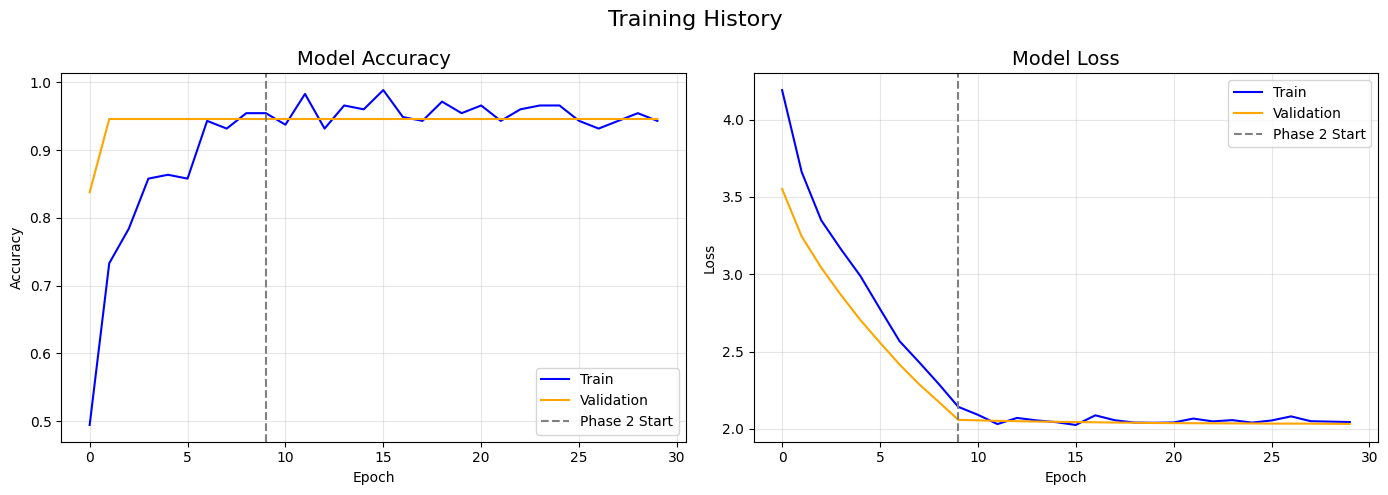

In [30]:
# Combine histories
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history.get(key, [])
    return combined

history = combine_histories(history_phase1, history_phase2)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history['accuracy'], label='Train', color='blue')
axes[0].plot(history['val_accuracy'], label='Validation', color='orange')
axes[0].axvline(x=len(history_phase1.history['accuracy'])-1, color='gray',
                linestyle='--', label='Phase 2 Start')
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history['loss'], label='Train', color='blue')
axes[1].plot(history['val_loss'], label='Validation', color='orange')
axes[1].axvline(x=len(history_phase1.history['loss'])-1, color='gray',
                linestyle='--', label='Phase 2 Start')
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=16)
plt.tight_layout()
plt.savefig(str(DRIVE_PATH / 'training_curves.png'), dpi=300)
plt.show()

## 10. Model Evaluation

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Get predictions
test_generator.reset()
y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Compute metrics
metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'F1-Score': f1_score(y_true, y_pred)
}

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
metrics['Specificity'] = tn / (tn + fp)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
metrics['AUC'] = auc(fpr, tpr)

print("=" * 50)
print("EVALUATION RESULTS (Test Set)")
print("=" * 50)
for name, value in metrics.items():
    print(f"{name:12}: {value:.4f} ({value*100:.1f}%)")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step
EVALUATION RESULTS (Test Set)
Accuracy    : 0.8750 (87.5%)
Precision   : 0.8800 (88.0%)
Recall      : 0.9167 (91.7%)
F1-Score    : 0.8980 (89.8%)
Specificity : 0.8125 (81.2%)
AUC         : 0.9505 (95.1%)


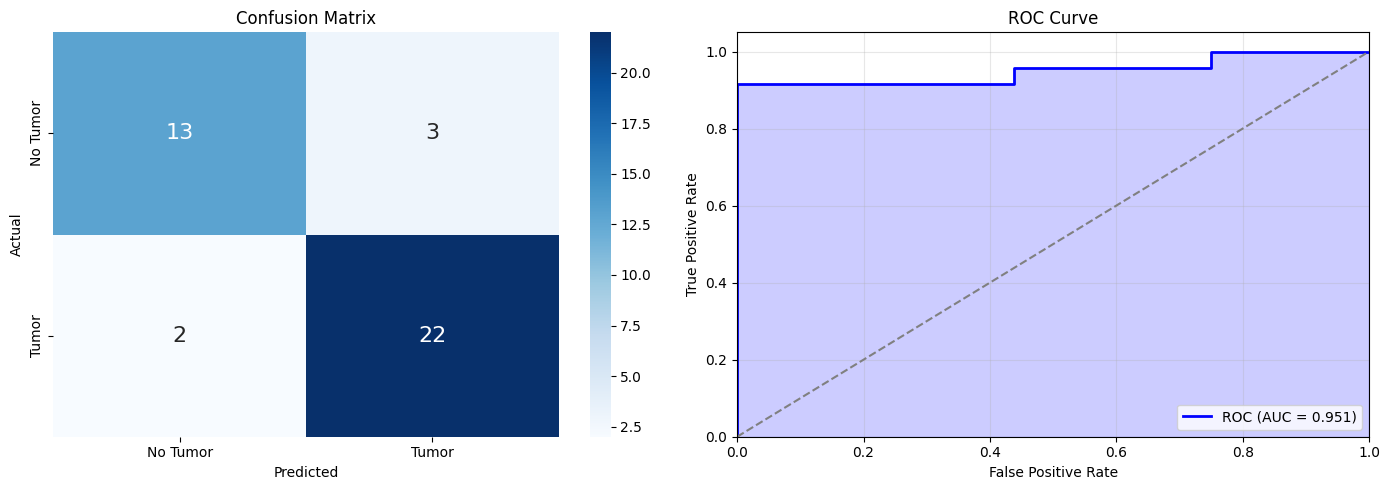


Confusion Matrix Breakdown:
  True Positives (tumors caught):    22
  True Negatives (healthy confirmed): 13
  False Positives (false alarms):    3
  False Negatives (MISSED TUMORS):   2  ⚠️


In [32]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            ax=axes[0], annot_kws={'size': 16})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC Curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {metrics["AUC"]:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].fill_between(fpr, tpr, alpha=0.2, color='blue')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(DRIVE_PATH / 'evaluation_results.png'), dpi=300)
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Positives (tumors caught):    {tp}")
print(f"  True Negatives (healthy confirmed): {tn}")
print(f"  False Positives (false alarms):    {fp}")
print(f"  False Negatives (MISSED TUMORS):   {fn}  ⚠️")

## 11. Download Model

Download the trained model to your local machine for deployment:

In [33]:
from google.colab import files

model_path = MODEL_DIR / 'vgg16_brain_tumor.h5'
print(f"Downloading model from: {model_path}")
files.download(str(model_path))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 12. Summary

### Training Complete! ✅

**What was accomplished:**
1. Dataset analyzed and class imbalance identified
2. Data split into train/val/test (70/15/15)
3. Brain regions extracted using CV pipeline
4. VGG-16 model trained with two-phase approach
5. Model evaluated on test set

**Next Steps:**
1. Download the model (`vgg16_brain_tumor.h5`)
2. Place in `saved_models/` directory of your local project
3. Run Streamlit app: `streamlit run app/streamlit_app.py`

---

⚠️ **Disclaimer:** This model is for educational/demonstration purposes only. Not for clinical use.